In [94]:
import numpy as np
import matplotlib.pyplot as plt

In [95]:
def per_round_spread_based_strat(p_t, a_t, b, alpha):
    """
    Based on Algorithm 1
    p_t: p_t, the current price
    a_t: a_t, the left bound of the current window
    b: the window size
    alpha: the liquidity density
    """
    if p_t < a_t:
        a_next = p_t
    elif p_t > a_t + b:
        a_next = p_t - b
    else:
        a_next = a_t

    def limit_order(p):
        """
        p: price at which shares are desired to be bought/sold; p \in possible_prices
        """
        if (a_next <= p) and (p <= a_next + b):
            return 0
        elif p > p_t: # sales
            return alpha
        else: # purchases
            return alpha
    return limit_order, a_next

def spread_based_strat(b, T, prices, a1, possible_prices, alpha): # quantities available at each price level? should be # {time} x {price}
    """
    b: window size
    T: time horizon
    prices: [p_t]_{t = 1}^T
    a1: initial price p_1
    """
    holdings = [0]
    cash = [0]
    portfolio_values = [0]
    window_left_bounds = [a1]
    for t in range(1, T):
        current_limit_order, a_next = per_round_spread_based_strat(
            prices[t], 
            window_left_bounds[-1], 
            b, alpha
        )
        window_left_bounds.append(a_next)

        # see page 3, section Limit Order
        if prices[t] > prices[t-1]:
            for p in [p for p in possible_prices if (prices[t-1] < p) and (p <= prices[t])]:
                cash.append(cash[-1] + (p * current_limit_order(p)))
                holdings.append(holdings[-1] - current_limit_order(p))

        elif prices[t] < prices[t-1]:
            for p in [p for p in possible_prices if (prices[t] <= p) and (p < prices[t-1])]:
                cash.append(cash[-1] - (p * current_limit_order(p)))
                holdings.append(holdings[-1] + current_limit_order(p))

        portfolio_values.append(cash[-1] + (prices[t] * holdings[-1]))

        # now use current_limit_order to purchase
    return cash, holdings, portfolio_values, window_left_bounds

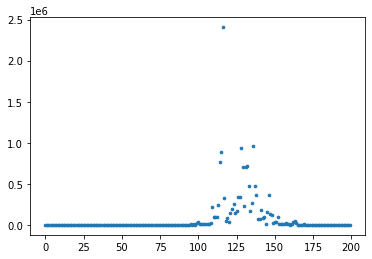

In [136]:
b = 1e-1 # window size
delta = 1e-2 # discretization resolution of prices; can be assumed to be the reciprocal of an int
alpha = 1e-2 # liquidity density
M = 50 # upper bound on prices
possible_prices = [p * delta for p in range(int(M / delta))] # notation: capital pi

T = 200
bernoulli_steps = (2 * np.random.binomial(1, 0.5, size=(T ** 2))) - 1
discrete_bm = (1 / np.sqrt(T)) * np.array([5e-2 * t + bernoulli_steps[:int(np.floor(T * t))].sum() for t in range(T)])
plt.scatter(range(T), np.exp(discrete_bm), s=7)
plt.show()

prices = discrete_bm

In [130]:
cash, holdings, portfolio_values, window_left_bounds = spread_based_strat(
    b, T, 
    prices, prices[0], 
    possible_prices, 
    alpha
)

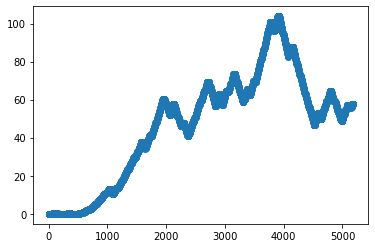

In [131]:
plt.scatter(range(len(cash)), cash)

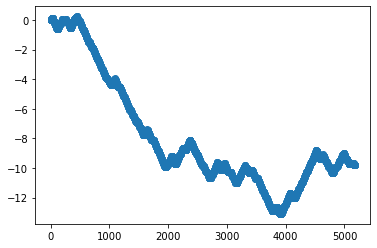

In [132]:
plt.scatter(range(len(holdings)), holdings)

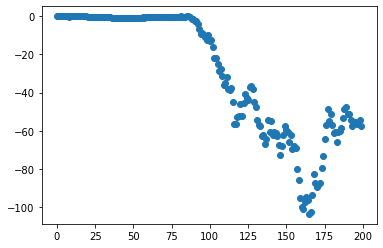

In [133]:
plt.scatter(range(len(portfolio_values)), portfolio_values)